In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import xgboost
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
print("xgboost", xgboost.__version__)
from matplotlib import pyplot
import seaborn as sns
from xgboost import plot_importance, plot_tree

root_path = 'gdrive/MyDrive'
path = Path(root_path)
filename = 'final_.csv'


xgboost 0.90


In [3]:
df_final = pd.read_csv(path/filename, dtype={'line_total_order_qty' : int, 'dock_imp_day' : "string"})
df_final['date'] = pd.to_datetime(df_final['date'])

In [4]:
# Calculate different in pricing from MSRP, this field is already in the final_.csv. Needs only for original file
# df_final['dis_from_msrp'] = ((df_final['regular_price'] - df_final['possible_final_price']) / df_final['regular_price'])

# Set reg, mk and overall not in % by dividing on 100 May be it;s not nescessary. IMHO these features are not important in out model 
df_final['reg'] =df_final['reg']/100
df_final['mk'] =df_final['mk']/100
df_final['overall'] =df_final['overall']/100

# change name of the week with numbers 0..6
df_final['week_day'] = pd.to_datetime(df_final['date']).dt.dayofweek

# Add column with the week from the first date we have in dataframe.
# Used this to calculate mean of line_total_order_qty.
# Fot the training of the model going to try to use not the sales for one day,
# but instead an average sales of the product for the week.
df_final['period'] = ((pd.to_datetime(df_final['date']) - pd.to_datetime('2018-03-31')).dt.days/7).astype(int)
df_final['avg_toq_per_week'] = df_final.groupby(['pc9', 'period'])['line_total_order_qty'].transform('mean')


df_final['dock_imp_day']= df_final['dock_imp_day'].astype(str)

In [5]:
def time_encoding(series, freq, max_val=None):
    if freq == 'day_of_week' or freq == 'weekday': freq = 'dayofweek'
    elif freq == 'day_of_month' or freq == 'dayofmonth': freq = 'day'
    elif freq == 'day_of_year': freq = 'dayofyear'
    available_freqs = ['microsecond', 'millisecond', 'second', 'minute', 'hour', 'day', 'dayofweek', 'dayofyear', 'week', 'month', 'year']
    assert freq in available_freqs
    if max_val is None:
        idx = available_freqs.index(freq)
        max_val = [1_000_000, 1_000, 60, 60, 24, 31, 7, 366, 53, 12, 10][idx]
    try:
        series = series.to_series()
    except:
        pass
    if freq == 'microsecond': series = series.dt.microsecond
    elif freq == 'millisecond': series = series.dt.microsecond // 1_000
    elif freq == 'second': series = series.dt.second
    elif freq == 'minute': series = series.dt.minute
    elif freq == 'hour': series = series.dt.hour
    elif freq == 'day': series = series.dt.day
    elif freq == 'dayofweek': series = series.dt.dayofweek
    elif freq == 'dayofyear': series = series.dt.dayofyear
    elif freq == 'week': series = series.dt.isocalendar().week
    elif freq == 'month': series = series.dt.month
    elif freq == 'year': series = series.dt.year - series.dt.year // 10 * 10
    sin = np.sin(series.values / max_val * 2 * np.pi)
    cos = np.cos(series.values / max_val * 2 * np.pi)
    return sin, cos

In [6]:
month_sin, month_cos  = time_encoding(df_final['date'], freq = 'month')
df_final['month_sin'] = month_sin
df_final['month_cos'] = month_cos
month_sin, month_cos
day_sin, day_cos  = time_encoding(df_final['date'], freq = 'day')
df_final['month_day_sin'] = day_sin
df_final['month_day_cos'] = day_cos
week_day_sin, week_day_cos  = time_encoding(df_final['date'], freq = 'dayofweek')
df_final['week_day_sin'] = week_day_sin
df_final['week_day_cos'] = week_day_cos

df_final.head()

,date,days_until_promo_ends,next_us_hday,prev_us_hday,month,month_day,week_day,days_until_payday,pc9,gender,size_group,style,interacted_price,pricing,pc3,pc5,category,product_item_type,fit,regular_price,overall,reg,mk,major_minimum_value,major_multiple_items,site_wide,upto,special,markdown,non_markdown,spend_paid_social,spend_paid_search,spend_affiliate,spend_cses,spend_display,spend_total_demand_generation,dock_imp_day,pricing_period,possible_final_price,selected,LM_unit_sold_monthly_mean,LM_unit_sold_monthly_sum_rolling_mean_3,LM_overall_unit_sold_monthly_mean,line_total_order_qty,dis_from_msrp,period,avg_toq_per_week,month_sin,month_cos,month_day_sin,month_day_cos,week_day_sin,week_day_cos
0,2018-03-31,1.0,58.0,40.0,3.0,31.0,5,0.0,38,0,1,26,32.97,0,9,12,2,10,7,58.0,0.25,0.25,0.25,1.0,0.0,0.0,0.0,0.0,0.0,0.0,12665.0,64140.0,27209.0,11792.0,0.0,115806.0,Easter,1,24.7275,0.0,-999.0,-999.0,-999.0,3,0.573664,0,0.428571,1.0,6.123234e-17,-2.449294e-16,1.0,-0.974928,-0.222521
1,2018-03-31,1.0,58.0,40.0,3.0,31.0,5,0.0,43,0,1,33,58.00,1,11,15,2,10,1,58.0,0.25,0.25,0.25,1.0,0.0,0.0,0.0,0.0,0.0,0.0,12665.0,64140.0,27209.0,11792.0,0.0,115806.0,Easter,1,43.5000,0.0,-999.0,-999.0,-999.0,2,0.250000,0,3.000000,1.0,6.123234e-17,-2.449294e-16,1.0,-0.974928,-0.222521
2,2018-03-31,1.0,58.0,40.0,3.0,31.0,5,0.0,44,0,1,33,58.00,1,11,15,2,10,1,58.0,0.25,0.25,0.25,1.0,0.0,0.0,0.0,0.0,0.0,0.0,12665.0,64140.0,27209.0,11792.0,0.0,115806.0,Easter,1,43.5000,0.0,-999.0,-999.0,-999.0,4,0.250000,0,1.857143,1.0,6.123234e-17,-2.449294e-16,1.0,-0.974928,-0.222521
3,2018-03-31,1.0,58.0,40.0,3.0,31.0,5,0.0,45,0,1,33,58.00,1,11,15,2,10,1,58.0,0.25,0.25,0.25,1.0,0.0,0.0,0.0,0.0,0.0,0.0,12665.0,64140.0,27209.0,11792.0,0.0,115806.0,Easter,1,43.5000,0.0,-999.0,-999.0,-999.0,1,0.250000,0,1.285714,1.0,6.123234e-17,-2.449294e-16,1.0,-0.974928,-0.222521
4,2018-03-31,1.0,58.0,40.0,3.0,31.0,5,0.0,46,0,1,33,32.97,0,11,15,2,10,1,58.0,0.25,0.25,0.25,1.0,0.0,0.0,0.0,0.0,0.0,0.0,12665.0,64140.0,27209.0,11792.0,0.0,115806.0,Easter,1,24.7275,0.0,-999.0,-999.0,-999.0,1,0.573664,0,3.714286,1.0,6.123234e-17,-2.449294e-16,1.0,-0.974928,-0.222521


In [7]:
df_final.columns

Index(['date', 'days_until_promo_ends', 'next_us_hday', 'prev_us_hday',
       'month', 'month_day', 'week_day', 'days_until_payday', 'pc9', 'gender',
       'size_group', 'style', 'interacted_price', 'pricing', 'pc3', 'pc5',
       'category', 'product_item_type', 'fit', 'regular_price', 'overall',
       'reg', 'mk', 'major_minimum_value', 'major_multiple_items', 'site_wide',
       'upto', 'special', 'markdown', 'non_markdown', 'spend_paid_social',
       'spend_paid_search', 'spend_affiliate', 'spend_cses', 'spend_display',
       'spend_total_demand_generation', 'dock_imp_day', 'pricing_period',
       'possible_final_price', 'selected', 'LM_unit_sold_monthly_mean',
       'LM_unit_sold_monthly_sum_rolling_mean_3',
       'LM_overall_unit_sold_monthly_mean', 'line_total_order_qty',
       'dis_from_msrp', 'period', 'avg_toq_per_week', 'month_sin', 'month_cos',
       'month_day_sin', 'month_day_cos', 'week_day_sin', 'week_day_cos'],
      dtype='object')

Will use one item for the model prediction. 

In [17]:
pc9 = 1831
df_pc9=df_final[df_final.pc9 == pc9].copy()
df_pc9.shape[1]

#pc5=335
#df_pc5=df_final[df_final.pc5 == pc5].copy()
#df_pc5.shape[1]

53

In [18]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols = list()
    for i in range(n_in, 0, -1):
      cols.append(df.shift(i))
    for i in range(0, n_out):
      cols.append(df.shift(-i))
    agg = pd.concat(cols, axis=1)
    if dropnan:
      agg.dropna(inplace=True)
    return agg.values

In [41]:
features = ['month_cos', 'month_day_cos', 'week_day_sin', 'week_day_cos','interacted_price', 'LM_unit_sold_monthly_mean','line_total_order_qty']
data = df_pc9[features].copy()
data.tail(10)

,month_cos,month_day_cos,week_day_sin,week_day_cos,interacted_price,LM_unit_sold_monthly_mean,line_total_order_qty
780353,-0.5,0.688967,0.974928,-0.222521,34.99,-999.0,0
780354,-0.5,0.528964,0.433884,-0.900969,34.99,-999.0,0
780355,-0.5,0.347305,-0.433884,-0.900969,34.99,-999.0,0
780356,-0.5,0.688967,0.974928,-0.222521,29.97,-999.0,1
780357,-0.5,0.528964,0.433884,-0.900969,29.97,-999.0,0
780358,-0.5,0.347305,-0.433884,-0.900969,29.97,-999.0,0
780359,-0.5,0.528964,0.433884,-0.900969,59.99,-999.0,2
780360,-0.5,0.347305,-0.433884,-0.900969,59.99,-999.0,0
780361,-0.5,0.528964,0.433884,-0.900969,59.99,-999.0,1
780362,-0.5,0.347305,-0.433884,-0.900969,59.99,-999.0,0


In [42]:
def train_test_split(data, n_test):
    return data[:-n_test, :], data[-n_test:, :]

In [43]:
def xgboost_forecast(train, testx):
    # transform list into array
    train = np.asarray(train)
    # split into input and output columns
    trainx, trainy = train[:, :-1], train[:, -1]
    # fit model
    model = xgboost.XGBRegressor(objective = 'reg:squarederror', n_estimators=1000, iterations = 50, od_type = 'Iter')
    #objective='reg:squarederror', n_estimators=1000)
    model.fit(trainx, trainy)
    # make a one-step prediction
    yhat = model.predict(np.asarray([testx]))
    return yhat[0]

In [44]:
def walk_forward_validation(data, n_test):
    predictions = list()
    train, test = train_test_split(data, n_test)
    history = [x for x in train]
    for i in range(len(test)):
        testx, testy = test[i, :-1], test[i, -1]
        yhat = xgboost_forecast(history, testx)
        predictions.append(yhat)
        history.append(test[i])
        print('>expected=%.1f, predicted=%.1f' % (testy, yhat))   
    error = mean_absolute_error(test[:, -1], predictions)
    return error, test[:, -1], predictions

In [ ]:
d = series_to_supervised(data, n_in=6, n_out=3)
print (d)
mae, y, yhat = walk_forward_validation(d, 60)
#print('MAE: %.3f' % mae)

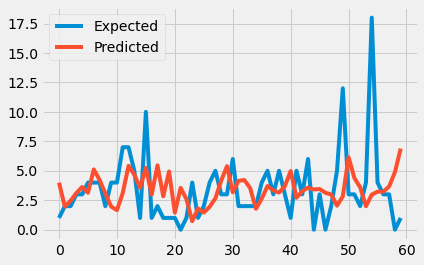

In [34]:
plt.style.use('fivethirtyeight')
pyplot.plot(y, label='Expected')
pyplot.plot(yhat, label='Predicted')
pyplot.legend()
pyplot.show()

In [25]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

import plotly.express as px
print("MAE XB: ", mean_absolute_error(y,yhat))
print('R2 XB: ', r2_score(y,yhat))

def MAPE(y,yhat): 
  y,yhat = np.array(y), np.array(yhat)
  return np.mean(np.abs((y - yhat) / np.maximum(np.ones(len(y)), np.abs(y))))*100
print('MAPE XB: ', MAPE(y,yhat))

MAE XB:  2.1965154071648914
R2 XB:  -0.2089051717692343
MAPE XB:  103.5615181867723


In [26]:
sum(yhat)
sum(y)
(sum(yhat)-sum(y))/sum(y)

0.009252876043319702